# В данной работе требуется определить малоприбыльные рейсы из Анапы в зимнее время года #

## Описание признаков


**flight_id** - идентификатор рейса  
**flight_no**-номер рейса   
**departure_city**-город вылета   
**arrival_city**-город прилета   
**actual_departure**-фактическое время вылета   
**actual_arrival**-фактическое время прилёта   
**flight_time**-время полета  
**model**-модель самолета   
**aircraft_code**-код самолета   
**economy_seat**-количество мест в эконом-классе    
**business_seat**-количество мест в бизнес-классе    
**total_seat**-общее количество мест    
**economy_sold**-количество проданных билетов в эконом-класс  
**business_sold**-количество проданных билетов в бизнес-класс  
**total_sold**-общее количество проданных билетов  
**economy_amount**-выручка от продажи билетов в эконом-класс  
**business_amount**-выручка от продажи билетов в бизнес-класс  
**total_amount**-общая выручка от продажи билетов  

In [375]:
import pandas as pd
from datetime import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
pd.set_option('display.max_rows', 50)  # показывать больше строк
pd.set_option('display.max_columns', 50)
df = pd.read_csv('query_result.csv')

Смотрим данные

In [376]:
df.head()

,flight_id,flight_no,departure_city,arrival_city,actual_departure,actual_arrival,flight_time,model,aircraft_code,economy_seat,business_seat,total_seat,economy_sold,business_sold,total_sold,economy_amount,business_amount,total_amount
0,136698,PG0480,Anapa,Belgorod,2016-12-01T09:30:00Z,2016-12-01T10:19:00Z,49.0,Sukhoi Superjet-100,SU9,85,12,97,82.0,12.0,94.0,519600.0,226800.0,746400.0
1,136187,PG0252,Anapa,Moscow,2016-12-01T10:09:00Z,2016-12-01T11:49:00Z,100.0,Boeing 737-300,733,118,12,130,117.0,12.0,129.0,1434600.0,439200.0,1873800.0
2,136774,PG0480,Anapa,Belgorod,2016-12-02T09:27:00Z,2016-12-02T10:17:00Z,50.0,Sukhoi Superjet-100,SU9,85,12,97,81.0,12.0,93.0,513300.0,226800.0,740100.0
3,136474,PG0252,Anapa,Moscow,2016-12-02T10:06:00Z,2016-12-02T11:44:00Z,98.0,Boeing 737-300,733,118,12,130,118.0,12.0,130.0,1446800.0,439200.0,1886000.0
4,136873,PG0480,Anapa,Belgorod,2016-12-03T09:26:00Z,2016-12-03T10:17:00Z,51.0,Sukhoi Superjet-100,SU9,85,12,97,84.0,12.0,96.0,532200.0,226800.0,759000.0


In [377]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193 entries, 0 to 192
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   flight_id         193 non-null    int64  
 1   flight_no         193 non-null    object 
 2   departure_city    193 non-null    object 
 3   arrival_city      193 non-null    object 
 4   actual_departure  193 non-null    object 
 5   actual_arrival    193 non-null    object 
 6   flight_time       193 non-null    float64
 7   model             193 non-null    object 
 8   aircraft_code     193 non-null    object 
 9   economy_seat      193 non-null    int64  
 10  business_seat     193 non-null    int64  
 11  total_seat        193 non-null    int64  
 12  economy_sold      180 non-null    float64
 13  business_sold     180 non-null    float64
 14  total_sold        180 non-null    float64
 15  economy_amount    180 non-null    float64
 16  business_amount   180 non-null    float64
 1

In [378]:
df.flight_id.nunique()

193

Датасет содержит 193 уникальные строки и 18 колонок  
Пропуски имеются в небольшом количестве  
Колонки **actual_departure, actual_arrival** содержат данные о датах и времени и требует присвоения формата datetime

Удаляем пустые значения

In [379]:
df.dropna(inplace=True)

Определим, в какие города осуществляются полеты

In [380]:
print(f'{df.arrival_city.unique()}')

['Belgorod' 'Moscow']


Какие самолеты используются

In [381]:
print(f'{df.model.unique()}')

['Sukhoi Superjet-100' 'Boeing 737-300']


Количество рейсов по направлениям полетов для каждой модели самолета

In [382]:
df.groupby(['model','arrival_city']).flight_id.count()

model                arrival_city
Boeing 737-300       Moscow          90
Sukhoi Superjet-100  Belgorod        90
Name: flight_id, dtype: int64

Выделим данные по каждому направлению

In [383]:
df_moscow = df[df.arrival_city == 'Moscow']
df_belgorod = df[df.arrival_city == 'Belgorod']

## Создание новых признаков ##

Необходимо исправить тип данных в колонках, которые несут информацию о дате и времени. Добавить признак дня недели, когда осуществлялся рейс

In [384]:
df.actual_arrival = pd.to_datetime(df.actual_departure)
df.actual_departure = pd.to_datetime(df.actual_arrival)
df.loc[:, 'weekday'] = df.actual_arrival.apply(lambda x: x.weekday() + 1)
weekday = {1: 'ПН', 2: 'ВТ', 3: 'СР', 4: 'ЧТ', 5: 'ПТ', 6: 'СБ', 7: 'ВС'}
df.weekday = df.weekday.map(weekday)

Приведем время полета к минутам

In [385]:
df.flight_time = df.flight_time / 60

На основании данных из открытых источников по расходу топлива для каждой модели самолета (#https://www.airlines-inform.ru
#https://favt.gov.ru/dejatelnost-ajeroporty-i-ajerodromy-ceny-na-aviagsm/), определим затраты на топливо

In [386]:
def fuel_consumption(row):
    if row.model == 'Sukhoi Superjet-100':
        return 0.028
    elif row.model == 'Boeing 737-300':
        return 0.04


df['fuel_consumption'] = df.apply(fuel_consumption, axis=1)
df['fuel_cost'] = df.flight_time * df.fuel_consumption * 40494

Определим процент заполненных мест в самолете во время рейса

In [387]:
df['percent_seat'] = round(df['total_sold']/df['total_seat'], 2)

Определим прибыль как разность стоимости билетов и затрат на топливо

In [388]:
df['profit'] = df['total_amount'] - df['fuel_cost']

## Проанализируем полученные результаты

Построим диаграмму распределения прибыли по направлениям рейсов

In [393]:
def get_boxplot(column):
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.boxplot(x=column, y='profit',
                data=df.loc[df.loc[:, column].isin(
                    df.loc[:, column].value_counts().index[:10])], palette="Reds",
                ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

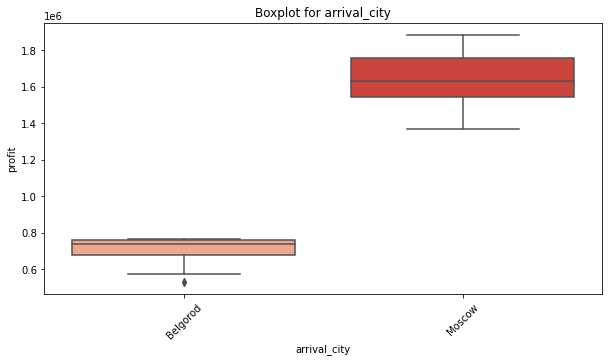

In [394]:
get_boxplot('arrival_city')

Посмотрим, как влияет день недели на количество людей на рейсе

[Text(0.5, 0, 'День недели'),
 Text(0, 0.5, 'Заполненность самолетов в Белгород')]

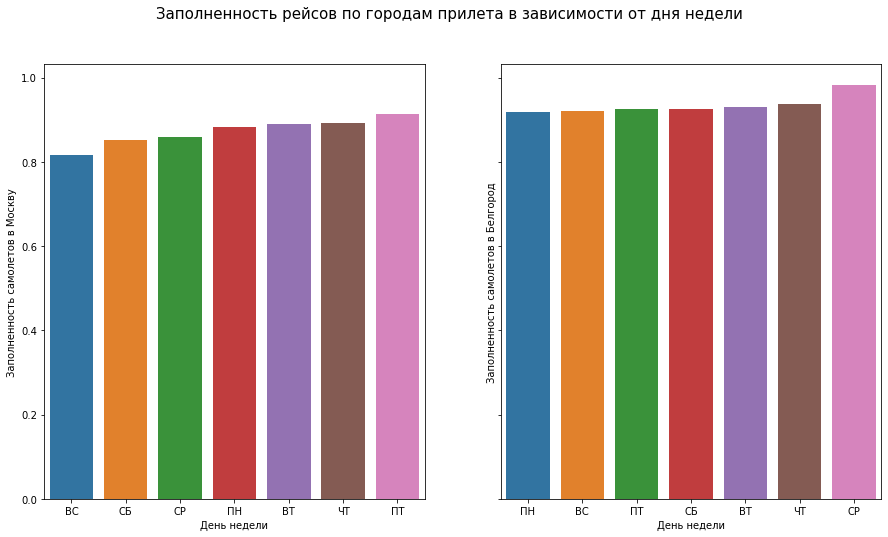

In [396]:
fig, ax = plt.subplots(1, 2, figsize=(15, 8), sharey=True)
fig.suptitle(
    'Заполненность рейсов по городам прилета в зависимости от дня недели', fontsize=15)
sns.barplot(data=moscow, y='percent_seat', x=moscow.index,
            order=moscow.sort_values(by='percent_seat').index, ax=ax[0])
sns.barplot(data=belgorod, y='percent_seat', x=belgorod.index,
            order=belgorod.sort_values(by='percent_seat').index, ax=ax[1])
ax[0].set(xlabel='День недели', ylabel='Заполненность самолетов в Москву')
ax[1].set(xlabel='День недели', ylabel='Заполненность самолетов в Белгород')

Определим зависимость прибыли от количества человек на борту рейса

Text(0, 0.5, 'Заполненность')

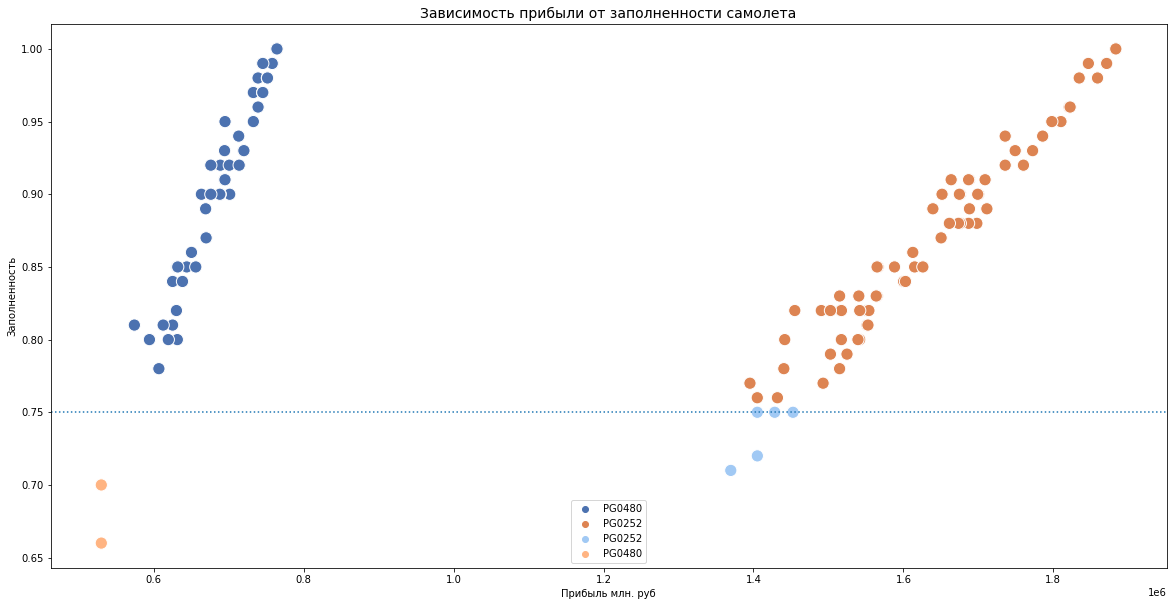

In [401]:
df_1 = df[df.percent_seat > 0.75]
df_2 = df[df.percent_seat <= 0.75]

fig, ax = plt.subplots(figsize=(20, 10))
sns.scatterplot(x='profit', y='percent_seat', data=df_1,
                hue='flight_no', s=150, palette="deep")
sns.scatterplot(x='profit', y='percent_seat', data=df_2,
                hue='flight_no', s=150, palette="pastel")
sns.set_color_codes('pastel')
plt.axhline(0.75, linestyle=':')
ax.legend(loc=8)
ax.set_title(
    'Зависимость прибыли от заполненности самолета', fontsize=14)
ax.set_xlabel('Прибыль млн. руб')
ax.set_ylabel('Заполненность')

При заполненности менее 75% рейс является нерентабельным. Посмотрим такие рейсы

In [400]:
df[df.percent_seat < 0.75]

,flight_id,flight_no,departure_city,arrival_city,actual_departure,actual_arrival,flight_time,model,aircraft_code,economy_seat,business_seat,total_seat,economy_sold,business_sold,total_sold,economy_amount,business_amount,total_amount,weekday,fuel_consumption,fuel_cost,percent_seat,profit
20,136352,PG0252,Anapa,Moscow,2016-12-10 10:10:00+00:00,2016-12-10 10:10:00+00:00,1.666667,Boeing 737-300,733,118,12,130,82.0,10.0,92.0,1006400.0,366000.0,1372400.0,СБ,0.040,2699.6000,0.71,1.369700e+06
50,136253,PG0252,Anapa,Moscow,2016-12-24 10:08:00+00:00,2016-12-24 10:08:00+00:00,1.633333,Boeing 737-300,733,118,12,130,82.0,11.0,93.0,1005200.0,402600.0,1407800.0,СБ,0.040,2645.6080,0.72,1.405154e+06
128,136642,PG0480,Anapa,Belgorod,2017-01-30 09:28:00+00:00,2017-01-30 09:28:00+00:00,0.816667,Sukhoi Superjet-100,SU9,85,12,97,54.0,10.0,64.0,342000.0,189000.0,531000.0,ПН,0.028,925.9628,0.66,5.300740e+05
180,136807,PG0480,Anapa,Belgorod,2017-02-23 09:28:00+00:00,2017-02-23 09:28:00+00:00,0.833333,Sukhoi Superjet-100,SU9,85,12,97,60.0,8.0,68.0,379800.0,151200.0,531000.0,ЧТ,0.028,944.8600,0.70,5.300551e+05


Посмотрим корреляционную матрицу со следующими признаками

In [462]:
cor = ['profit','flight_time','economy_seat','total_sold','fuel_consumption','fuel_cost']
df[cor].corr()

,profit,flight_time,economy_seat,total_sold,fuel_consumption,fuel_cost
profit,1.000000,0.971806,0.973656,0.908821,0.973656,0.972321
flight_time,0.971806,1.000000,0.999431,0.796751,0.999431,0.999945
economy_seat,0.973656,0.999431,1.000000,0.799171,1.000000,0.999710
total_sold,0.908821,0.796751,0.799171,1.000000,0.799171,0.797190
fuel_consumption,0.973656,0.999431,1.000000,0.799171,1.000000,0.999710
fuel_cost,0.972321,0.999945,0.999710,0.797190,0.999710,1.000000


Text(0.5, 1.0, 'Корреляционная матрица')

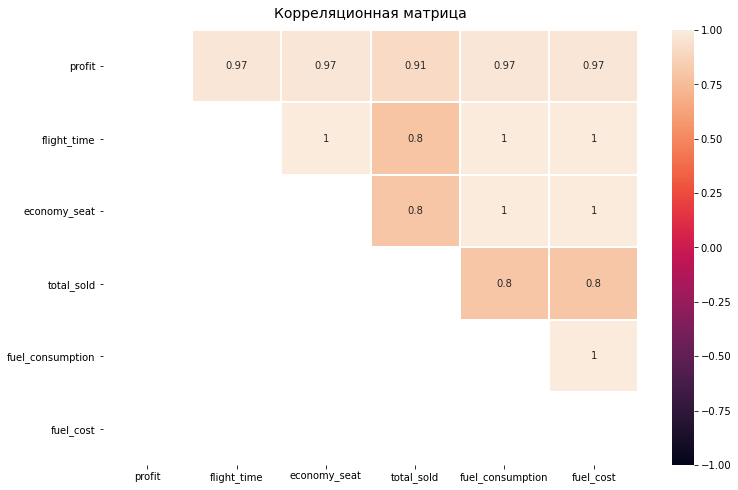

In [465]:
plt.figure(figsize=(12, 8))
matrix = np.tril(df[cor].corr())
heatmap = sns.heatmap(df[cor].corr(), mask=matrix, vmin=-1, vmax=1,
                      annot=True, linewidths=1)
heatmap.set_title('Корреляционная матрица', fontdict={'fontsize': 14}, pad=12)

Номера рейсов, которые следует убрать

In [468]:
#номера этих рейсов
flight_unprofit = list(df[df.percent_seat < 0.75].flight_id)
flight_unprofit

[136352, 136253, 136642, 136807]

Предполагаемая прибыльность этих рейсов

In [473]:
df_unprofit = pd.DataFrame(df[df.percent_seat < 0.75])
df_unprofit

,flight_id,flight_no,departure_city,arrival_city,actual_departure,actual_arrival,flight_time,model,aircraft_code,economy_seat,business_seat,total_seat,economy_sold,business_sold,total_sold,economy_amount,business_amount,total_amount,weekday,fuel_consumption,fuel_cost,percent_seat,profit
20,136352,PG0252,Anapa,Moscow,2016-12-10 10:10:00+00:00,2016-12-10 10:10:00+00:00,1.666667,Boeing 737-300,733,118,12,130,82.0,10.0,92.0,1006400.0,366000.0,1372400.0,СБ,0.040,2699.6000,0.71,1.369700e+06
50,136253,PG0252,Anapa,Moscow,2016-12-24 10:08:00+00:00,2016-12-24 10:08:00+00:00,1.633333,Boeing 737-300,733,118,12,130,82.0,11.0,93.0,1005200.0,402600.0,1407800.0,СБ,0.040,2645.6080,0.72,1.405154e+06
128,136642,PG0480,Anapa,Belgorod,2017-01-30 09:28:00+00:00,2017-01-30 09:28:00+00:00,0.816667,Sukhoi Superjet-100,SU9,85,12,97,54.0,10.0,64.0,342000.0,189000.0,531000.0,ПН,0.028,925.9628,0.66,5.300740e+05
180,136807,PG0480,Anapa,Belgorod,2017-02-23 09:28:00+00:00,2017-02-23 09:28:00+00:00,0.833333,Sukhoi Superjet-100,SU9,85,12,97,60.0,8.0,68.0,379800.0,151200.0,531000.0,ЧТ,0.028,944.8600,0.70,5.300551e+05


In [474]:
df_unprofit.groupby(['flight_id'])[
    'profit'].unique().sort_values(ascending=False)

flight_id
136253    [1405154.392]
136352      [1369700.4]
136642    [530074.0372]
136807      [530055.14]
Name: profit, dtype: object

Средняя прибыльность всех рейсов

In [475]:
round(df.profit.mean())

1177825